# Classificador Uber

O Brasil é um dos principais mercados da Uber no mundo e, por isso, suas principais categorias estão em operação no país.

Vale ressaltar que, durante sua abertura de capital, a Uber anunciou que, naquele momento, o Brasil era o segundo país que mais solicitava corridas do app no mundo, perdendo apenas para os EUA. Por isso, é evidente que o aplicativo tem uma visão especial para o país.

Atualmente, a empresa conta com quatorze categorias em operação no Brasil, sem falar da Uber Eats e da Cornershop, serviço de entregas de alimentos e mercado, respectivamente.

O objetivo desse projeto é aplicar técnicas de EDA e _machine learning_ para prever a categoria utilizada em determinada corrida de um banco de dados real*.

    * É importante frisar que a massa de dados original foi bastante "podada" para não causar nenhum problema de privacidade dos dados. 

## 1. Carregando os Dados

Importando a biblioteca necessária para carregar o banco de dados:

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

Carregando e exibindo o banco de dados:

In [3]:
df = pd.read_excel(r'C:\Users\arnon\Documents\Projetos\Classificador Uber\uber.xlsx')
df.head()

,Data da solicitação (local),Hora da solicitação (local),Serviço,Distância (mi),Duração (min),Grupo,Valor da transação em BRL (com tributos)
0,2020-01-18,01:33:00,Travel | UberX,10.18,21,Diretores,29.38
1,2020-01-18,11:19:00,Travel | UberX,2.25,12,--,8.79
2,2020-02-12,17:42:00,Travel | VIP,4.19,29,--,12.09
3,2020-02-13,04:49:00,Travel | UberX,12.41,29,Geral,28.46
4,2020-02-13,07:57:00,Travel | Comfort,22.72,46,Geral,74.95


Renomeando as colunas para facilitar a manipulação dos dados:

In [4]:
df.rename(columns = {'Data da solicitação (local)': 'data_solicitacao',
                    'Hora da solicitação (local)': 'hora_solicitacao', 'Serviço': 'categoria',
                    'Distância (mi)': 'distancia', 'Duração (min)': 'duracao', 'Grupo': 'grupo', 
                    'Valor da transação em BRL (com tributos)': 'preco'}, inplace = True)
df.head()

,data_solicitacao,hora_solicitacao,categoria,distancia,duracao,grupo,preco
0,2020-01-18,01:33:00,Travel | UberX,10.18,21,Diretores,29.38
1,2020-01-18,11:19:00,Travel | UberX,2.25,12,--,8.79
2,2020-02-12,17:42:00,Travel | VIP,4.19,29,--,12.09
3,2020-02-13,04:49:00,Travel | UberX,12.41,29,Geral,28.46
4,2020-02-13,07:57:00,Travel | Comfort,22.72,46,Geral,74.95


Com o banco carregado, é interessante fazer uma rápida descrição dos dados:

* __data_solicitacao__: data de solicitação do serviço de acordo com o fuso horário local
* __hora_solicitacao__: hora de solicitação do serviço de acordo com o fuso horário local
* __categoria__: categoria do uber
* __distancia__: distância percorrida na corrida [mi]
* __duracao__: duração da corrida [min]
* __grupo__: grupo do colaborador ("diretores" ou "geral")
* __preco__: valor da corrida [R$]

## 2. Preparando os Dados

Antes de qualquer preparo, é essencial levantar algumas informações básicas do dataframe.

Tamanho do dataset:

In [5]:
df.shape

(43642, 7)

Quantidade de nulos:

In [6]:
df.isna().sum()

data_solicitacao    0
hora_solicitacao    0
categoria           0
distancia           0
duracao             0
grupo               0
preco               0
dtype: int64

Tipo dos dados:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43642 entries, 0 to 43641
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   data_solicitacao  43642 non-null  datetime64[ns]
 1   hora_solicitacao  43642 non-null  object        
 2   categoria         43642 non-null  object        
 3   distancia         43642 non-null  object        
 4   duracao           43642 non-null  object        
 5   grupo             43642 non-null  object        
 6   preco             43642 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 2.3+ MB


Na célula anterior, é possível observar que o tipo de dados de algumas colunas retornou diferente do esperado. Dessa forma, faremos algumas manipulações no banco para resolver essa questão.

Convertendo a coluna de distância em decimal:

In [8]:
# df['distancia'] = df['distancia'].astype(float)

O erro do comando anterior indica que existe algum registro estranho na coluna "distancia". Assim, primeiro será necessário lidar com esse erro.

Verificando a representatividade dais linhas com erro em relação a amostra de dados:

In [9]:
print(df[df['distancia'] == "--"].shape[0]*100/df.shape[0],'%')

1.3633655652811512 %


Como a quantidade de linhas com entradas ruins representa uma parcela muito pequena da amostra, iremos descartar esses dados:

In [10]:
df.drop(df[df['distancia'] == "--"].index, inplace = True)

Verificando o resultado no tamanho do banco de dados:

In [11]:
df.shape

(43047, 7)

Executando novamente o comando de conversão para a coluna "distancia":

In [12]:
df['distancia'] = df['distancia'].astype(float)

Convertendo a coluna de "duração" para inteiro:

In [13]:
df['duracao'] = df['duracao'].astype(int)

No resultado do comando "head" realizado anteriormente, é possível notar que a coluna "grupo" também possui valores que devemos tratar. Novamente, vamos verificar a representatividade dessa massa:

In [14]:
print(df[(df['grupo'] != 'Geral') & (df['grupo'] != 'Diretores')].shape[0]*100/df.shape[0],'%')

18.600599344902083 %


Como o percentual de ocorrências discriminado acima é muito elevado, iremos supor que o "grupo" dessas entradas é "Geral": 

In [15]:
df['grupo'] = df['grupo'].replace('--', 'Geral')

Por fim, só nos resta consertar o tipo de variável da coluna "hora_solicitacao". No entanto, considerando o contexto do projeto em questão, iremos dispensar o impacto da hora da solicitação e deixar essa análise para uma futura versão do código.

In [16]:
df.drop(columns = 'hora_solicitacao', inplace = True)

Verificando o resultado final:

In [17]:
df.head()

,data_solicitacao,categoria,distancia,duracao,grupo,preco
0,2020-01-18,Travel | UberX,10.18,21,Diretores,29.38
1,2020-01-18,Travel | UberX,2.25,12,Geral,8.79
2,2020-02-12,Travel | VIP,4.19,29,Geral,12.09
3,2020-02-13,Travel | UberX,12.41,29,Geral,28.46
4,2020-02-13,Travel | Comfort,22.72,46,Geral,74.95


## 3. Enriquecendo os Dados

Como não iremos incluir nenhuma informação relativa a feriados, é mais interessante ter as datas em dias da semana do que em formato corrido:

In [18]:
df['dia_semana'] = df['data_solicitacao'].dt.day_name()
df.head()

,data_solicitacao,categoria,distancia,duracao,grupo,preco,dia_semana
0,2020-01-18,Travel | UberX,10.18,21,Diretores,29.38,Saturday
1,2020-01-18,Travel | UberX,2.25,12,Geral,8.79,Saturday
2,2020-02-12,Travel | VIP,4.19,29,Geral,12.09,Wednesday
3,2020-02-13,Travel | UberX,12.41,29,Geral,28.46,Thursday
4,2020-02-13,Travel | Comfort,22.72,46,Geral,74.95,Thursday


Excluindo a coluna "data_solicitacao":

In [19]:
df.drop(columns = 'data_solicitacao', inplace = True)
df.head()

,categoria,distancia,duracao,grupo,preco,dia_semana
0,Travel | UberX,10.18,21,Diretores,29.38,Saturday
1,Travel | UberX,2.25,12,Geral,8.79,Saturday
2,Travel | VIP,4.19,29,Geral,12.09,Wednesday
3,Travel | UberX,12.41,29,Geral,28.46,Thursday
4,Travel | Comfort,22.72,46,Geral,74.95,Thursday


Considerando também que o maior diferencial entre as categorias do Uber é o ticket médio [R$ / mi], vamos criar essa variável

In [20]:
df['ticket_medio'] = df['preco'] / df['distancia']
df.head()

,categoria,distancia,duracao,grupo,preco,dia_semana,ticket_medio
0,Travel | UberX,10.18,21,Diretores,29.38,Saturday,2.886051
1,Travel | UberX,2.25,12,Geral,8.79,Saturday,3.906667
2,Travel | VIP,4.19,29,Geral,12.09,Wednesday,2.885442
3,Travel | UberX,12.41,29,Geral,28.46,Thursday,2.293312
4,Travel | Comfort,22.72,46,Geral,74.95,Thursday,3.298856


Antes de excluirmos as colunas "preco" e "distancia", é importante passarmos pela etapa de "análise dos dados" para verificar a integridade da coluna "ticket_medio" criada.

## 4. Analisando os Dados

Começaremos essa etapa com uma análise descritiva dos dados numéricos:

In [21]:
df.describe()

,distancia,duracao,preco,ticket_medio
count,43047.000000,43047.000000,43047.000000,4.304700e+04
mean,9.244175,26.328385,33.714128,inf
std,8.813901,20.490758,30.632266,NaN
min,0.000000,0.000000,3.950000,5.571587e-01
25%,3.300000,13.000000,15.230000,2.901199e+00
50%,6.910000,21.000000,24.920000,3.776786e+00
75%,12.100000,34.000000,41.030000,5.404336e+00
max,136.550000,447.000000,573.810000,inf


Pelo retorno anterior, podemos ver a ocorrência de dois problemas: _outliers_ na massa de dados e valores originais prejudicando a variável calculada "ticket_medio".

Começando pelo dado "ticket_medio", iremos verificar a ocorrências de distâncias nulas que retornam valores "inf" para a métrica calculada:

In [22]:
df[df['distancia'] == 0]

,categoria,distancia,duracao,grupo,preco,dia_semana,ticket_medio
893,Travel | UberX,0.0,0,Geral,9.00,Thursday,inf
894,Travel | UberX,0.0,0,Geral,9.00,Thursday,inf
2334,Travel | UberX,0.0,1,Geral,9.32,Thursday,inf
2535,Travel | UberX,0.0,5,Geral,5.35,Thursday,inf
3853,Travel | UberX,0.0,0,Geral,7.36,Friday,inf
11471,Travel | UberX,0.0,0,Geral,22.77,Monday,inf
34792,Travel | UberX,0.0,3,Geral,24.93,Thursday,inf
37136,Travel | Comfort,0.0,0,Geral,10.74,Monday,inf
37231,Travel | UberX,0.0,36,Geral,19.15,Tuesday,inf
37295,Travel | UberX,0.0,36,Geral,28.84,Tuesday,inf


Confirmamos nossa teoria e, para o projeto em questão, excluiremos essas entradas:

In [23]:
df.drop(df[df['distancia'] == 0].index, inplace = True)

E, agora, podemos excluir as colunas "distancia" e "preço":

In [24]:
df.drop(columns = ['distancia', 'preco'], inplace = True)
df.head()

,categoria,duracao,grupo,dia_semana,ticket_medio
0,Travel | UberX,21,Diretores,Saturday,2.886051
1,Travel | UberX,12,Geral,Saturday,3.906667
2,Travel | VIP,29,Geral,Wednesday,2.885442
3,Travel | UberX,29,Geral,Thursday,2.293312
4,Travel | Comfort,46,Geral,Thursday,3.298856


Verificando o tamanho do banco de dados resultante:

In [25]:
df.shape

(43036, 5)

Obs.: mudança de 43047 linhas para 43036 (redução inferior a 1%)

Para a avaliação dos _outliers_ da massa de dados, utilizaremos elementos gráficos.

Importando as bibliotecas necessárias:

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

Criando uma lista com as colunas numéricas:

In [27]:
cols_num = ['duracao', 'ticket_medio']

Plotando os gráficos de _boxplot_:

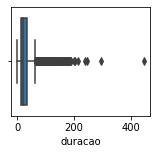

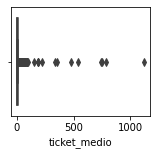

In [28]:
for i in cols_num:
    plt.figure(figsize = (2.5,2))
    sns.boxplot(x = df[i])
    plt.show()

Após a análise dos gráficos acima, foi realizada uma verificação da fonte de dados para confirmar a sua integridade. A princípio, todos os registros parecem corretos e, por isso, os _outliers_ serão mantidos nesse momento.

## 5. Visualizando os Dados

Agora que as primeiras análises foram efetuadas, começaremos a parte de "visualização dos dados" para checarmos se alguma outra manipulação é necessária.

Criando uma lista para as variáveis categóricas:

In [29]:
cols_cat = ['categoria', 'grupo', 'dia_semana']

Plotando a quantidade de entradas das colunas categóricas:

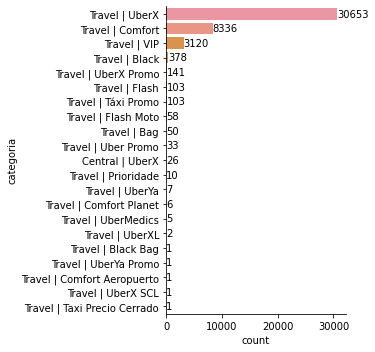

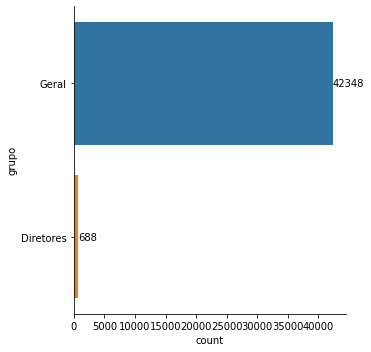

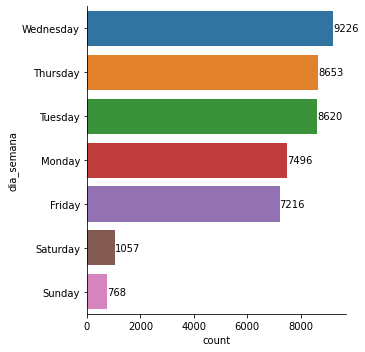

In [30]:
for i in cols_cat:
    fig = sns.catplot(data = df, y = i, kind = 'count', order = df[i].value_counts().index)
    ax = fig.facet_axis(0,0)
    for i in ax.containers:
        labels = [v.get_width() for v in i]
        ax.bar_label(i, labels = labels)

Como a quantidade de categorias Uber é bem desbalanceada, iremos realizar uma simplificação dessa coluna para tentar não enviesar o modelo de classificação:

In [31]:
df['categoria'] = df['categoria'].replace(['Travel | UberX', 'Travel | VIP', 'Travel | Comfort',
                                            'Travel | UberMedics', 'Travel | Uber Promo', 'Travel | Bag',
                                            'Travel | Black', 'Travel | UberX Promo', 'Central | UberX',
                                            'Travel | Flash', 'Travel | Táxi Promo', 'Travel | Flash Moto',
                                            'Travel | Black Bag', 'Travel | Prioridade',
                                            'Travel | Comfort Planet', 'Travel | UberYa Promo',
                                            'Travel | UberYa', 'Travel | UberXL', 'Travel | Comfort Aeropuerto',
                                            'Travel | UberX SCL', 'Travel | Taxi Precio Cerrado'],
                                            ['x', 'x', 'comfort', 'outros', 'outros', 'outros', 'black', 'x',
                                            'x', 'flash', 'outros', 'flash', 'black', 'outros', 'comfort',
                                            'outros', 'outros', 'outros', 'outros', 'x', 'outros'])

Verificando o resultado:

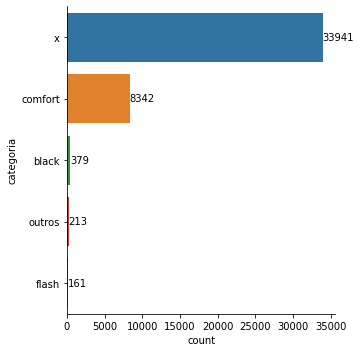

In [32]:
fig = sns.catplot(data = df, y = 'categoria', kind = 'count', order = df['categoria'].value_counts().index)
ax = fig.facet_axis(0,0)
for i in ax.containers:
    labels = [v.get_width() for v in i]
    ax.bar_label(i, labels = labels)

Apesar da simplificação da variável _target_, o resultado ainda não foi satisfatório. Por isso, utilizaremos apenas uma amostra das categorias _x_ e _comfort_ para balancear o banco de dados e realizar uma modelagem mais justa.

In [33]:
df_classe_x = df[df['categoria'] == 'x'].sample(2000)
df_classe_comfort = df[df['categoria'] == 'comfort'].sample(500)
df_classe_black = df[df['categoria'] == 'black']
df_classe_outros = df[df['categoria'] == 'outros']
df_classe_flash = df[df['categoria'] == 'flash']
df = pd.concat([df_classe_x, df_classe_comfort, df_classe_black, df_classe_outros, df_classe_flash])

Checando o resultado:

In [34]:
df.shape

(3253, 5)

Antes de passarmos para a análise visual das colunas numéricas, é importante lembrar que elas contêm muitos _outliers_. Esses valores atípicos podem distorcer uma distribuição de probabilidade e dificultar o dimensionamento dos dados usando normalização, pois a média calculada e o desvio padrão serão distorcidos pela presença desses dados.

Uma abordagem para padronizar variáveis de entrada na presença de _outliers_ é retirá-los do cálculo da média e do desvio padrão e, em seguida, usar os valores calculados para normalizar as variáveis.

Isso é chamado de "normalização robusta" ou "dimensionamento de dados robusto".

### 5.1. Preparando o Banco de Dados para a Normalização Robusta

Importando as biblitecas:

In [35]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Performando _one-hot encoding_ para a coluna grupo (categórica):

In [36]:
df_grupo = pd.DataFrame(OneHotEncoder().fit_transform(df[['grupo']]).toarray())
df_grupo.head()

,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


Juntando o _dataset_ grupo com o original:

In [37]:
df = pd.concat([df.reset_index(), df_grupo], axis = 1)
df.drop(columns = ['index'], inplace = True)
df.head()

,categoria,duracao,grupo,dia_semana,ticket_medio,0,1
0,x,24,Geral,Tuesday,3.754292,0.0,1.0
1,x,19,Geral,Monday,4.345936,0.0,1.0
2,x,20,Geral,Wednesday,3.705009,0.0,1.0
3,x,29,Geral,Thursday,3.157303,0.0,1.0
4,x,40,Geral,Thursday,3.199120,0.0,1.0


Dropando a coluna "grupo" e a coluna "1" e renomeando a coluna "0":

In [38]:
df.drop(columns = ['grupo', 1], inplace = True)
df.rename(columns = {0: 'diretores'}, inplace = True)
df.head()

,categoria,duracao,dia_semana,ticket_medio,diretores
0,x,24,Tuesday,3.754292,0.0
1,x,19,Monday,4.345936,0.0
2,x,20,Wednesday,3.705009,0.0
3,x,29,Thursday,3.157303,0.0
4,x,40,Thursday,3.199120,0.0


Para a coluna "dia_semana", iremos utilizar o método "_get_dummies_":

In [39]:
df = pd.get_dummies(df, columns = ['dia_semana'], prefix = '', prefix_sep = '')
df.head()

,categoria,duracao,ticket_medio,diretores,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,x,24,3.754292,0.0,0,0,0,0,0,1,0
1,x,19,4.345936,0.0,0,1,0,0,0,0,0
2,x,20,3.705009,0.0,0,0,0,0,0,0,1
3,x,29,3.157303,0.0,0,0,0,0,1,0,0
4,x,40,3.199120,0.0,0,0,0,0,1,0,0


### 5.2. Normalização Robusta

Realizando a divisão do banco de dados em variável dependentes, independente, treino e teste:

In [40]:
X = df.drop(columns = 'categoria')
y = df[['categoria']]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

Criando o escalonador:

In [42]:
scaler = RobustScaler().fit(X_train)

Escalonando o dataframe X:

In [43]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Transformando as partes de treino e teste para dataframe para visualizar o resultado:

In [44]:
X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [45]:
X_train.head()

,duracao,ticket_medio,diretores,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2.454545,0.672948,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.863636,1.214087,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.500000,-0.408513,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.045455,0.370131,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.681818,-0.055963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [46]:
X_test.head()

,duracao,ticket_medio,diretores,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0.636364,-0.430515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.227273,-0.034327,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.500000,-0.081969,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.045455,0.187360,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.181818,-0.271513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Reunindo as bases de treino e teste para a visualização dos dados numéricos:

In [47]:
df_scaled = pd.concat([X_train, X_test], ignore_index = True)

### 5.2. Visualizando os Dados Numéricos

Plotando gráficos de distribuição para as colunas numéricas normalizadas:

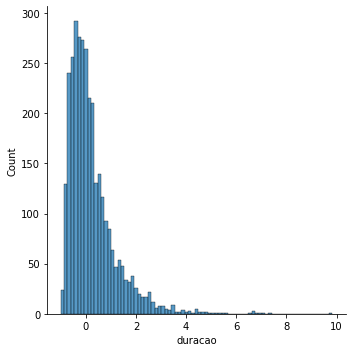

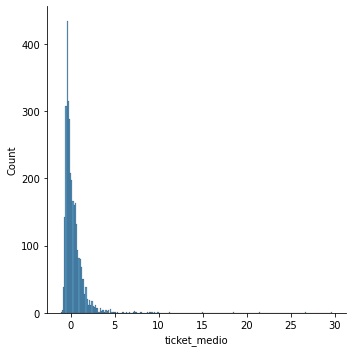

In [48]:
for i in cols_num:
    sns.displot(data = df_scaled, x = i)

## 6. Construindo o Modelo de Classificação

Importando as bibliotecas necessárias:

In [49]:
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

Criando e treinando o classificador:

In [50]:
clf = MLPClassifier(hidden_layer_sizes = 100).fit(X_train, np.ravel(y_train))

Gerando uma matriz de confusão para analisar a performance do modelo pelo número de casos Verdadeiros Positivos (TP), Verdadeiros Negativos (TN), Falsos Positivos (FP) e Falsos Negativos (FN):

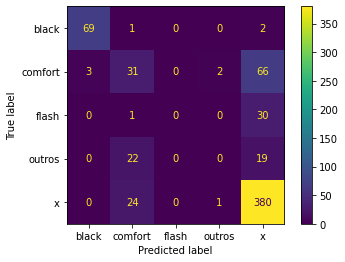

In [51]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

A matriz de confusão do modelo indica que ele é muito bom para classificar as categorias "black" e "x", mas tem bastante dificuldade com as outras. 

### 6.1. Tunning de Hiperparâmetros

Nesse item, iremos tentar melhorar o modelo por meio da aplicação da técnica de "_tunning_ de hiperparâmetros".

Importando a bibliteca necessária:

In [52]:
from sklearn.model_selection import GridSearchCV

Estipulando os parâmetros de variação para o _grid search_:

In [53]:
params = {'hidden_layer_sizes': range(500, 750, 125),
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'learning_rate': ['constant', 'invscaling', 'adaptive']}

Reiniciando o classificador:

In [54]:
clf = MLPClassifier()

Aplicando o _grid search_:

In [55]:
grid_search = GridSearchCV(clf, param_grid = params, n_jobs = -1).fit(X_train, np.ravel(y_train))

Exibindo os melhores parâmetros:

In [61]:
grid_search.best_params_

{'activation': 'tanh',
 'hidden_layer_sizes': 625,
 'learning_rate': 'invscaling',
 'solver': 'adam'}

Criando o classificador com os melhores parâmetros:

In [56]:
clf_best = grid_search.best_estimator_

## 7. Resultados

Verificando novamente a matriz de confusão do modelo:

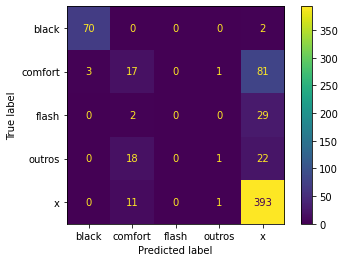

In [60]:
ConfusionMatrixDisplay.from_estimator(clf_best, X_test, y_test)

Predizendo os valores da base de teste:

In [57]:
y_pred = clf_best.predict(X_test)

Medindo a acurácia do modelo:

In [64]:
print(f'{accuracy_score(y_test, y_pred)*100}'+'%')

73.8863287250384%


In [67]:
clf_best.score(X_test, y_pred)

1.0

## 8. Conclusão

Por meio dos resultados obtidos, concluímos que o classificador não obteve um nível relevante de sucesso. Provavelmente, isso se deu pelo fato das variáveis independentes não serem suficientemente diferenciadoras e também pela sabida ocorrência dos "preços dinâmicos" do aplicativo Uber, que fazem com que a "hierarquia" das tarifas se altere em determinados contexto.

De toda forma, fica a experiência do desenvolvimento desse projeto e a possibilidade de melhorias para uma futura versão.